In [ ]:
#Author: [Abigail McConnell]
#Date Created: 2025-01-22
#Last Modified: 2025-05-26
#Script Name: Geomean_aerosol.py
#Description:
#    This script models the kinetics of HO2 uptake inside the flowtube. Working out th fractional loss of HO2 due to each reaction:
#    self-reaction, aerosol uptake and wall loss. 

k_self (s⁻¹): 4.91601438210301e-12


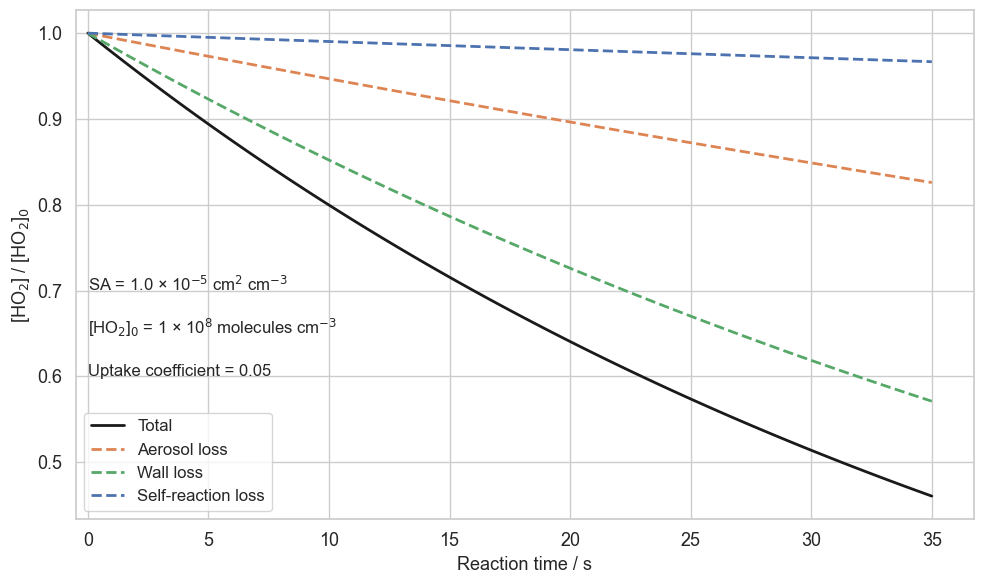

In [16]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from chempy.kinetics.ode import get_odesys
from chempy import Substance, ReactionSystem, Reaction
import seaborn as sns

# ======== Configuration and Constants ========
# Set plotting palette and matplotlib styling - inclduing changing the colour pallette 
sns.set_style("whitegrid")
palette = sns.color_palette()
plt.rcParams.update({
    "font.family": "Arial",
    'axes.labelsize': 13,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 12,
    'axes.titlesize': 13
})

# Physical constants and simulation parameters - these may need modifying depending on the conditions 
init_ho2 = 1e8                   # Initial HO2 concentration (molecules/cm³)
T = 298                          # Temperature (K)
P = 101325                       # Pressure (Pa)
y_ho2 = 0.05                     # HO2 uptake coefficient
SA = 1e-5                        # Aerosol surface area (cm²/cm³)
RH = 0.4                         # Relative humidity (fraction)
k_wall = 0.016                   # Wall loss rate (s⁻¹)
model_time = np.linspace(0, 35, 90)  # Time range for simulation (s)

# ======== equations  ========
k_B = 1.38e-23                   # Boltzmann constant (J/K)
M = P / (k_B * T) * 1e-6         # Number density (molecules/cm³)
w_ho2 = 43700                   # Mean thermal velocity of HO2 (cm/s)
SVP = 3169                      # Saturated vapor pressure of water (Pa)
ho2_conc = M * (SVP / P) * RH   # HO2 concentration from water vapor (molecules/cm³)

# Calculate rate constants for HO2 loss (aerosol loss, self-reaction and wall loss)
k_aerosol = ((y_ho2 * w_ho2) / 4) * SA
k_self = ((2.2e-13 * np.exp(600 / T)) + (1.9e-33 * M * np.exp(980 / T))) * \
         (1 + (1.4e-21 * ho2_conc * np.exp(2200 / T)))
k_wall_eff = k_wall - k_self

# ======== Reaction Definitions ========
# Define chemical species
substances = {
    "HO2": Substance("HO2"),
    "H2O2": Substance("H2O2"),
}

# Define reaction pathways
reactions = [
    Reaction({"HO2": 2}, {"H2O2": 1}, k_self),       # Self-reaction
    Reaction({"HO2": 1}, {}, k_aerosol),             # Aerosol loss
    Reaction({"HO2": 1}, {}, k_wall_eff),            # Wall loss
]

# Set up reaction system and ODEs
rsys = ReactionSystem(reactions, substances)
odesys, _ = get_odesys(rsys, params=True)
initial_conditions = defaultdict(float, {'HO2': init_ho2})
result = odesys.integrate(model_time, initial_conditions)

# Extract HO2 concentration over time
ho2_index = list(rsys.substances).index("HO2")
ho2_model = result.yout[:, ho2_index]

# ======== Analytical Approximations of Individual Loss Paths ========
# Individual loss pathway models for comparison
ho2_self = 1 / ((1 / init_ho2) + 2 * model_time * k_self)
ho2_aer = init_ho2 * np.exp(-k_aerosol * model_time)
ho2_wall = init_ho2 * np.exp(-k_wall_eff * model_time)

# ======== Plotting ========
plt.figure(figsize=(10, 6))

# Plot normalized concentrations
plt.plot(model_time, ho2_model / init_ho2, label='Total', color='k', linewidth=2)
plt.plot(model_time, ho2_aer / init_ho2, '--', label='Aerosol loss', color=palette[1], lw=2)
plt.plot(model_time, ho2_wall / init_ho2, '--', label='Wall loss', color=palette[2], lw=2)
plt.plot(model_time, ho2_self / init_ho2, '--', label='Self-reaction loss', color=palette[0], lw=2)

# Axis labels
plt.xlabel('Reaction time / s')
plt.ylabel('[HO$_2$] / [HO$_2$]$_0$')

# Format scientific annotations
SA_fmt = f"{SA:.1e}".split('e')
ho2_fmt = f"{init_ho2:.0e}".split('e')

plt.text(0, 0.7, f"SA = {SA_fmt[0]} × 10$^{{{int(SA_fmt[1])}}}$ cm$^2$ cm$^{{-3}}$", fontsize=12)
plt.text(0, 0.65, f"[HO$_2$]$_0$ = {ho2_fmt[0]} × 10$^{{{int(ho2_fmt[1])}}}$ molecules cm$^{{-3}}$", fontsize=12)
plt.text(0, 0.6, f"Uptake coefficient = {y_ho2:.2g}", fontsize=12)

plt.legend()
plt.xlim(-0.5)
plt.tight_layout()

# Uncomment to save figure
# plt.savefig('frac_loss_RH40_ho2_1e8_y_0.1_SA_1e-5.png', dpi=900)


# Output rate constant for verification/debugging
print("k_self (s⁻¹):", k_self)


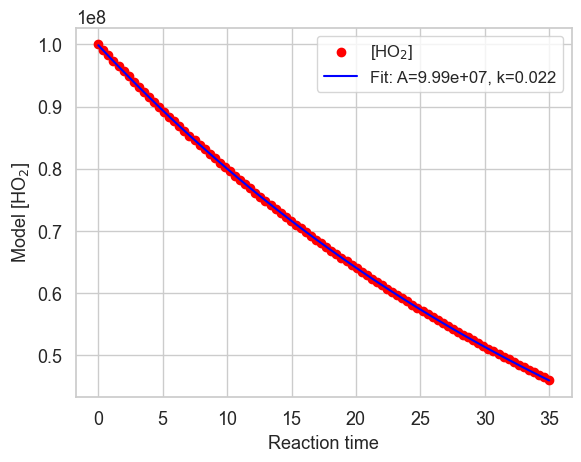

A_opt = 1e+08 ± 1.2e+04
k_opt = 0.0222 ± 7.54e-06
k_aerosol = 0.00546
k_wall = 0.016
k_self = 4.92e-12


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the exponential decay function
def exp_decay(x, A, k):
    return A * np.exp(-k * x)

# Input your X and Y data - may need modifying 
x_data = model_time
y_data = ho2_model

# Estimate A and k
A_guess = init_ho2
k_guess = k_aerosol

# Perform curve fitting
popt, pcov = curve_fit(exp_decay, x_data, y_data, p0=(A_guess, k_guess))
A_opt, k_opt = popt

k_error = np.sqrt(pcov[1, 1])
A_error = np.sqrt(pcov[0, 0])

# Plot results
plt.scatter(x_data, y_data, label="[HO$_2$]", color="red")
plt.plot(x_data, exp_decay(x_data, A_opt, k_opt), label=f"Fit: A={A_opt:.3g}, k={k_opt:.3f}", color="blue")
plt.ylabel("Model [HO$_2$]")
plt.xlabel("Reaction time")
plt.legend()
plt.show()

print(f"A_opt = {A_opt:.2g} ± {A_error:.2g}")
print(f"k_opt = {k_opt:.3g} ± {k_error:.3g}")
print(f"k_aerosol = {k_aerosol:.3g}")
print(f"k_wall = {k_wall:.3g}")
print(f"k_self = {k_self:.3g}")